In [2]:
from __future__ import division, print_function
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0

import sys
sys.path.append('/global/projecta/projectdirs/lsst/descqa/lib/descqa-conda/lib/python2.7/site-packages')
sys.path.append('/global/homes/j/jderose/.local/cori/2.7-anaconda/lib/python2.7/site-packages')
GCR_PATH = '/global/homes/j/jderose/.local/cori/2.7-anaconda/lib/python2.7/site-packages/generic-catalog-reader/'
sys.path.append(GCR_PATH)

In [3]:
from GCR import load_catalog

In [4]:
gc_buzzard = load_catalog(os.path.join(GCR_PATH, 'catalogs', 'buzzard_v1.5.yaml'))
gc_alphaq = load_catalog(os.path.join(GCR_PATH, 'catalogs', 'proto-dc2-v1.0.yaml'))

In [6]:
gc_buzzard.add_quantity_modifier('r_host', ('truth', 'RHALO'))
gc_buzzard.add_quantity_modifier('r_vir', ('truth', 'R200'))

In [7]:
data_buzzard = next(gc_buzzard.get_quantities(['redshift_true', 'Mag_true_r_any', 'mag_r_any', 'r_host', 'r_vir', 'halo_id', 'is_central', 'halo_mass'], 
                              return_iterator=True))

In [18]:
data_alphaq = next(gc_alphaq.get_quantities(['ra', 'dec', 'redshift_true', 'halo_id', 'subhalo_id', 'is_central', 'subhalo_mass', 'Mag_true_r_any'], 
                              return_iterator=True))

## Conditional Luminosity Function Tests

In [9]:
class Conditional_Luminosity_Function:
    
    def __init__(self, band='r', magnitude_bins=None, 
                 mass_bins=None, z_bins=None):
                 
        
        if magnitude_bins is None:
            magnitude_bins = np.linspace(-24,-18,30)
            
        if mass_bins is None:
            mass_bins = np.logspace(12,15,5)
            
        if z_bins is None:
            z_bins = np.linspace(0,0.5,3)

        self.absolute_magnitude_field = 'Mag_true_{}_any'.format(band)
        self.magnitude_bins           = magnitude_bins
        self.mass_bins                = mass_bins
        self.z_bins                   = z_bins
        
        self.n_magnitude_bins = len(self.magnitude_bins) - 1
        self.n_mass_bins      = len(self.mass_bins) - 1
        self.n_z_bins         = len(self.z_bins) - 1
        
#        self.has_nn_distance  = has_nn_distance
#        self.has_host_halo_mass = has_host_halo_mass
        
        self.sat_lum_counts = None
        self.cen_lum_counts   = None
        self.halo_counts          = None
        
        
    def map_validation(self, data):
        
        if 'r_host' in data.keys():
            self.has_nn_distance = True
        else:
            self.has_nn_distance = False
            
        if 'halo_mass' in data.keys():
            self.has_host_halo_mass = True
        else:
            self.has_host_halo_mass = False
        
        #initialize intermediate map quantities
        if self.sat_lum_counts is None:
            self.sat_lum_counts = np.zeros((self.n_magnitude_bins, 
                                                  self.n_mass_bins,
                                                  self.n_z_bins))
            self.cen_lum_counts   = np.zeros((self.n_magnitude_bins, 
                                                  self.n_mass_bins,
                                                  self.n_z_bins))
            self.halo_counts          = np.zeros((self.n_mass_bins,
                                                  self.n_z_bins))
            
        if not self.has_host_halo_mass:
            parent_id = data['subhalo_id'][data['is_central']]
            idx = parent_id.argsort()
            h_idx = np.searchsorted(parent_id[idx], data['halo_id'])
            parent_mass = data['subhalo_mass'][data['is_central']][idx][h_idx]
            
        else:
            parent_mass = data['halo_mass']
            
            
        #get satellite galaxies
        if self.has_nn_distance:
            sat_idx = (data['r_host'] < data['r_vir']) & (~data['is_central'])
        else:
            sat_idx = ~data['is_central']          
            
            
        for i, z in enumerate(self.z_bins[:-1]):
            
            z_idx  = ((self.z_bins[i] < data['redshift_true']) & 
                        (data['redshift_true'] < self.z_bins[i+1]))
            
            for j, m in enumerate(self.mass_bins[:-1]):
                m_idx = ((self.mass_bins[j] < parent_mass) 
                        & (parent_mass <= self.mass_bins[j+1]))
                m_idx = m_idx & z_idx

                self.halo_counts[j,i] += np.sum(data['is_central'][m_idx]==True)
                


                sc,e = np.histogram(data[self.absolute_magnitude_field][m_idx&sat_idx], bins=self.magnitude_bins)
                cc,e = np.histogram(data[self.absolute_magnitude_field][m_idx&data['is_central']], bins=self.magnitude_bins)
                self.sat_lum_counts[:,j,i] = sc
                self.cen_lum_counts[:,j,i] = cc


    def reduce_validation(self):
        
        delta_lum = self.magnitude_bins[1:] - self.magnitude_bins[:-1]
        
        self.sat_clf = self.sat_lum_counts / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1)
        self.cen_clf = self.cen_lum_counts / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1)
        self.tot_clf = ((self.sat_lum_counts  + self.cen_lum_counts)
                        / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1))

In [10]:
buzzard_clf = Conditional_Luminosity_Function()
alphaq_clf = Conditional_Luminosity_Function()

In [11]:
buzzard_clf.map_validation(data_buzzard)
alphaq_clf.map_validation(data_alphaq)

In [12]:
buzzard_clf.reduce_validation()
alphaq_clf.reduce_validation()

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


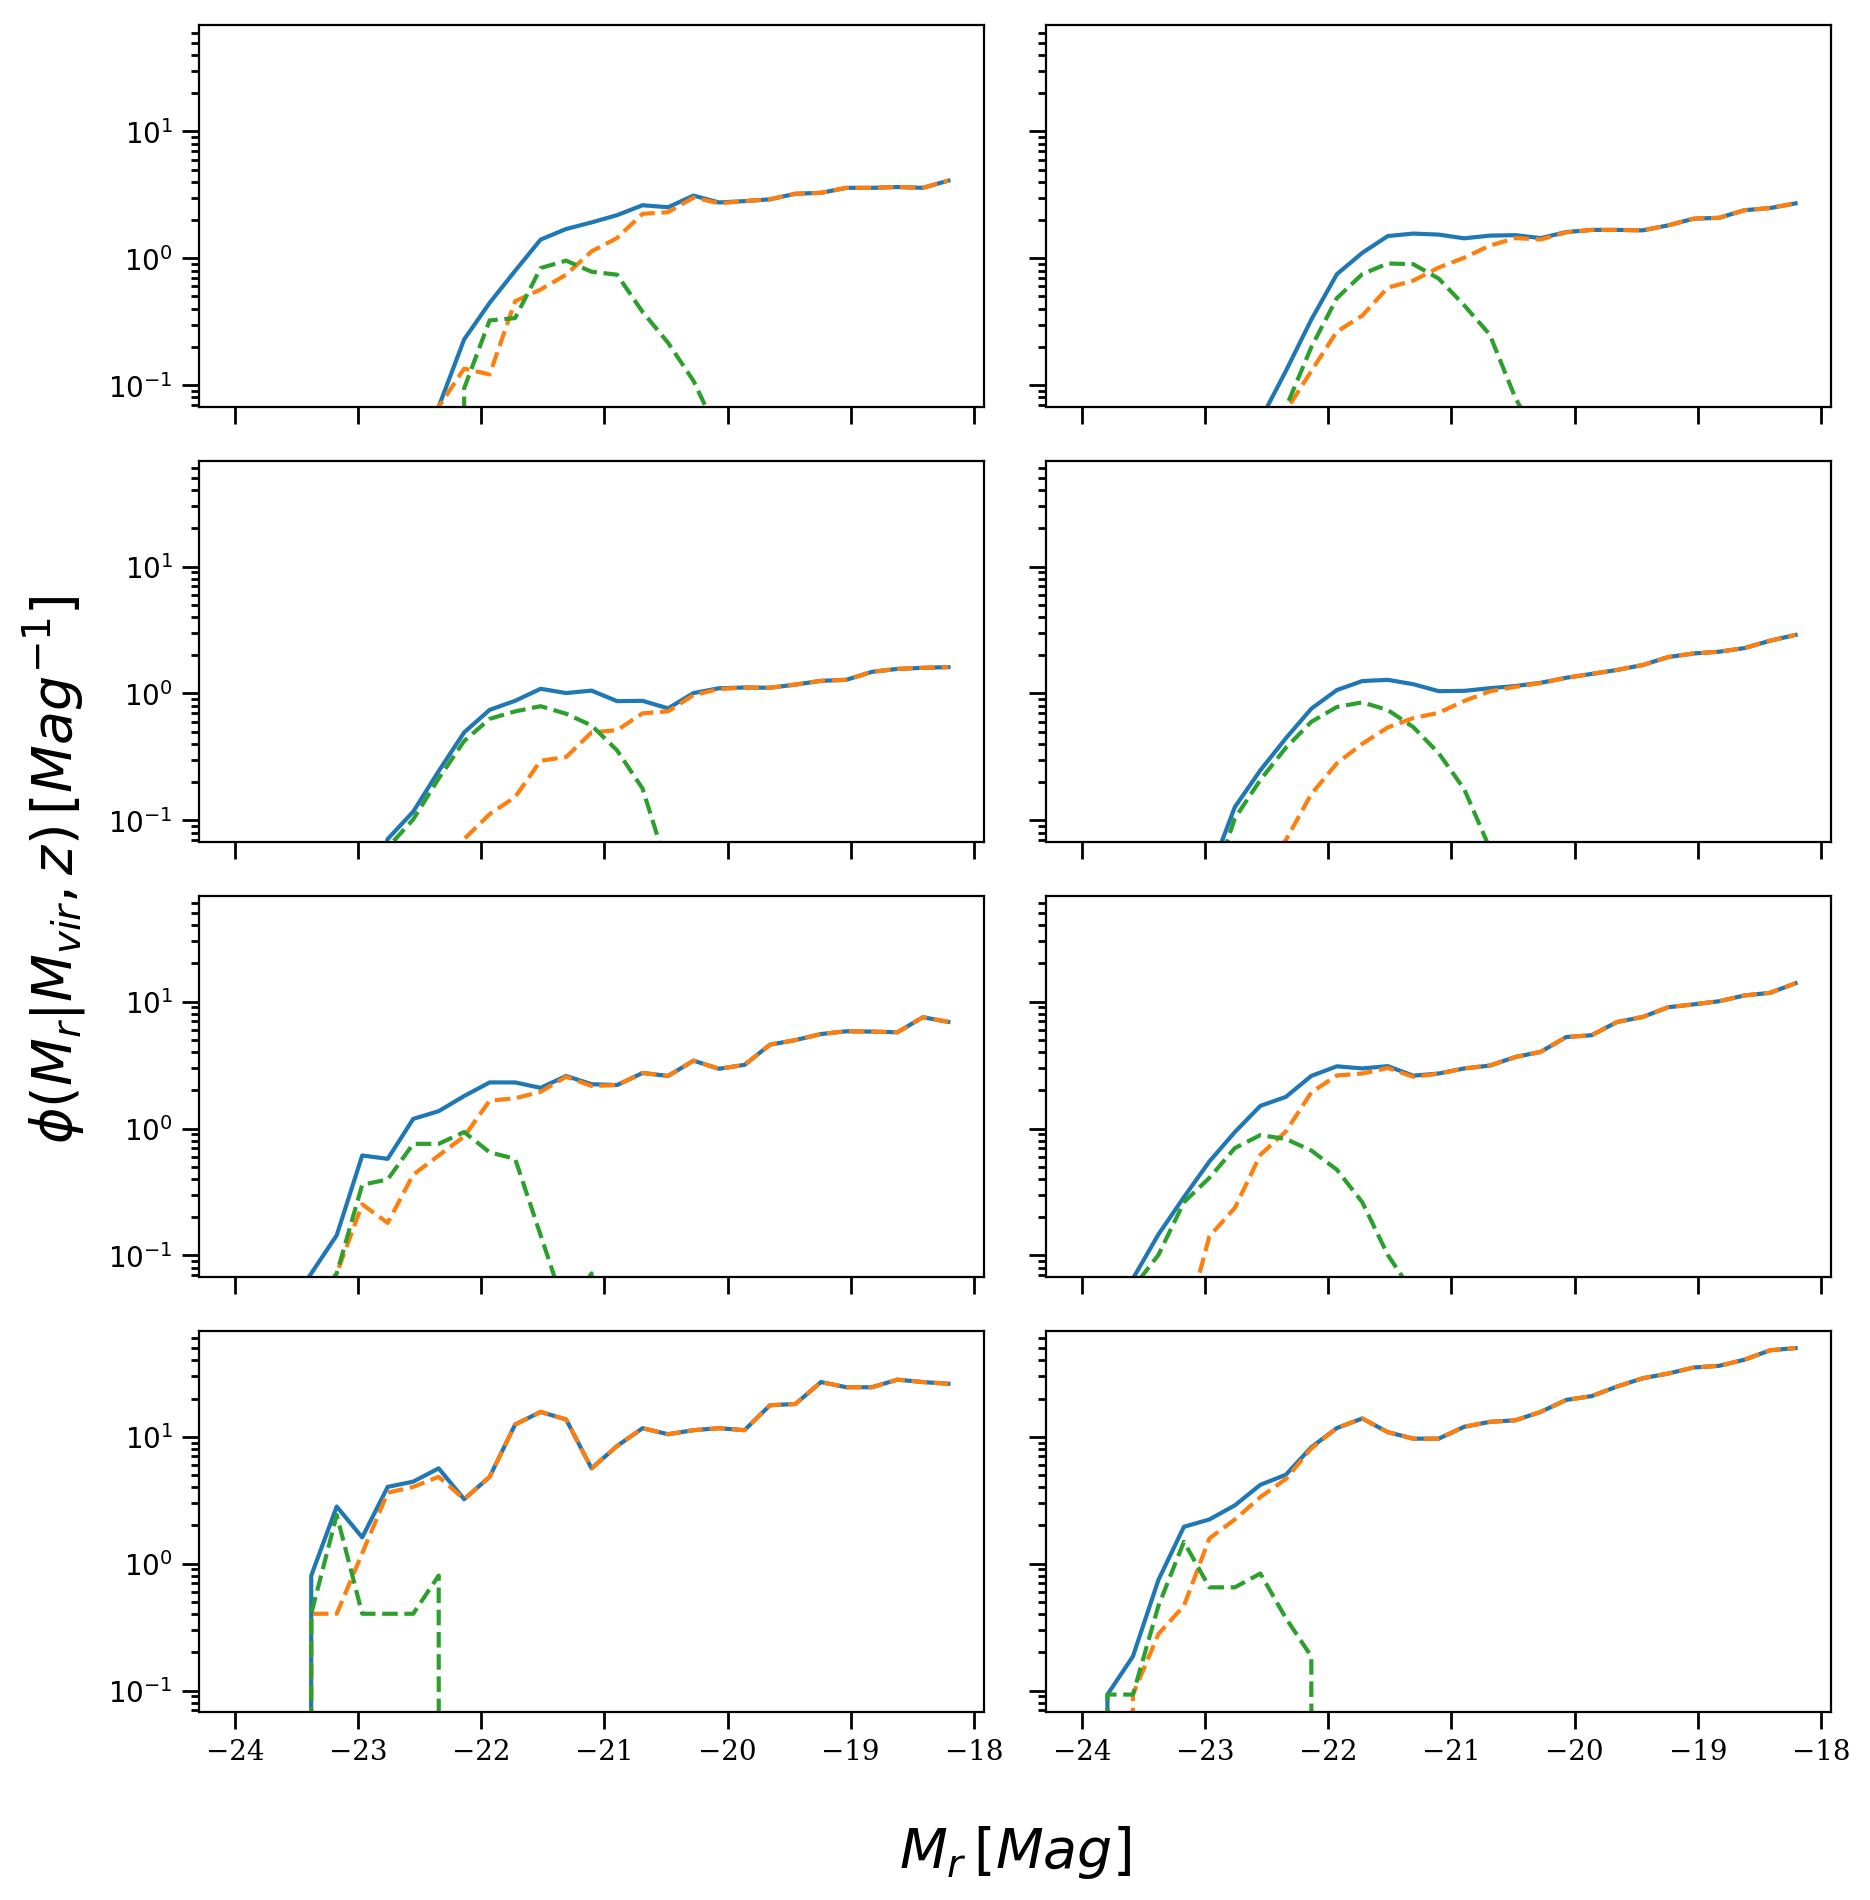

In [31]:
f, ax = plt.subplots(buzzard_clf.n_mass_bins, buzzard_clf.n_z_bins, sharex=True, sharey=True)

for i in range(buzzard_clf.n_z_bins):
    for j in range(buzzard_clf.n_mass_bins):
        ax[j,i].plot(buzzard_clf.magnitude_bins[:-1], buzzard_clf.tot_clf[:,j,i])
        ax[j,i].plot(buzzard_clf.magnitude_bins[:-1], buzzard_clf.sat_clf[:,j,i], '--')
        ax[j,i].plot(buzzard_clf.magnitude_bins[:-1], buzzard_clf.cen_clf[:,j,i], '--')
        
        ax[j,i].set_yscale('log')

        
sax = f.add_subplot(111)
plt.setp(sax.get_xticklines(), visible=False)
plt.setp(sax.get_yticklines(), visible=False)
plt.setp(sax.get_xticklabels(), visible=False)
plt.setp(sax.get_yticklabels(), visible=False)
sax.patch.set_alpha(0.0)
sax.patch.set_facecolor('none')
sax.spines['top'].set_color('none')
sax.spines['top'].set_alpha(0.0)
sax.spines['bottom'].set_color('none')
sax.spines['bottom'].set_alpha(0.0)
sax.spines['left'].set_color('none')
sax.spines['left'].set_alpha(0.0)
sax.spines['right'].set_color('none')
sax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
sax.set_ylabel(r'$\phi(M_{r}|M_{vir},z)\/[Mag^{-1}]$', labelpad=40, fontsize=20)
sax.set_xlabel(r'$M_{r}\/[Mag]$', labelpad=40, fontsize=20)
f.set_figheight(10)
f.set_figwidth(10)
plt.tight_layout()


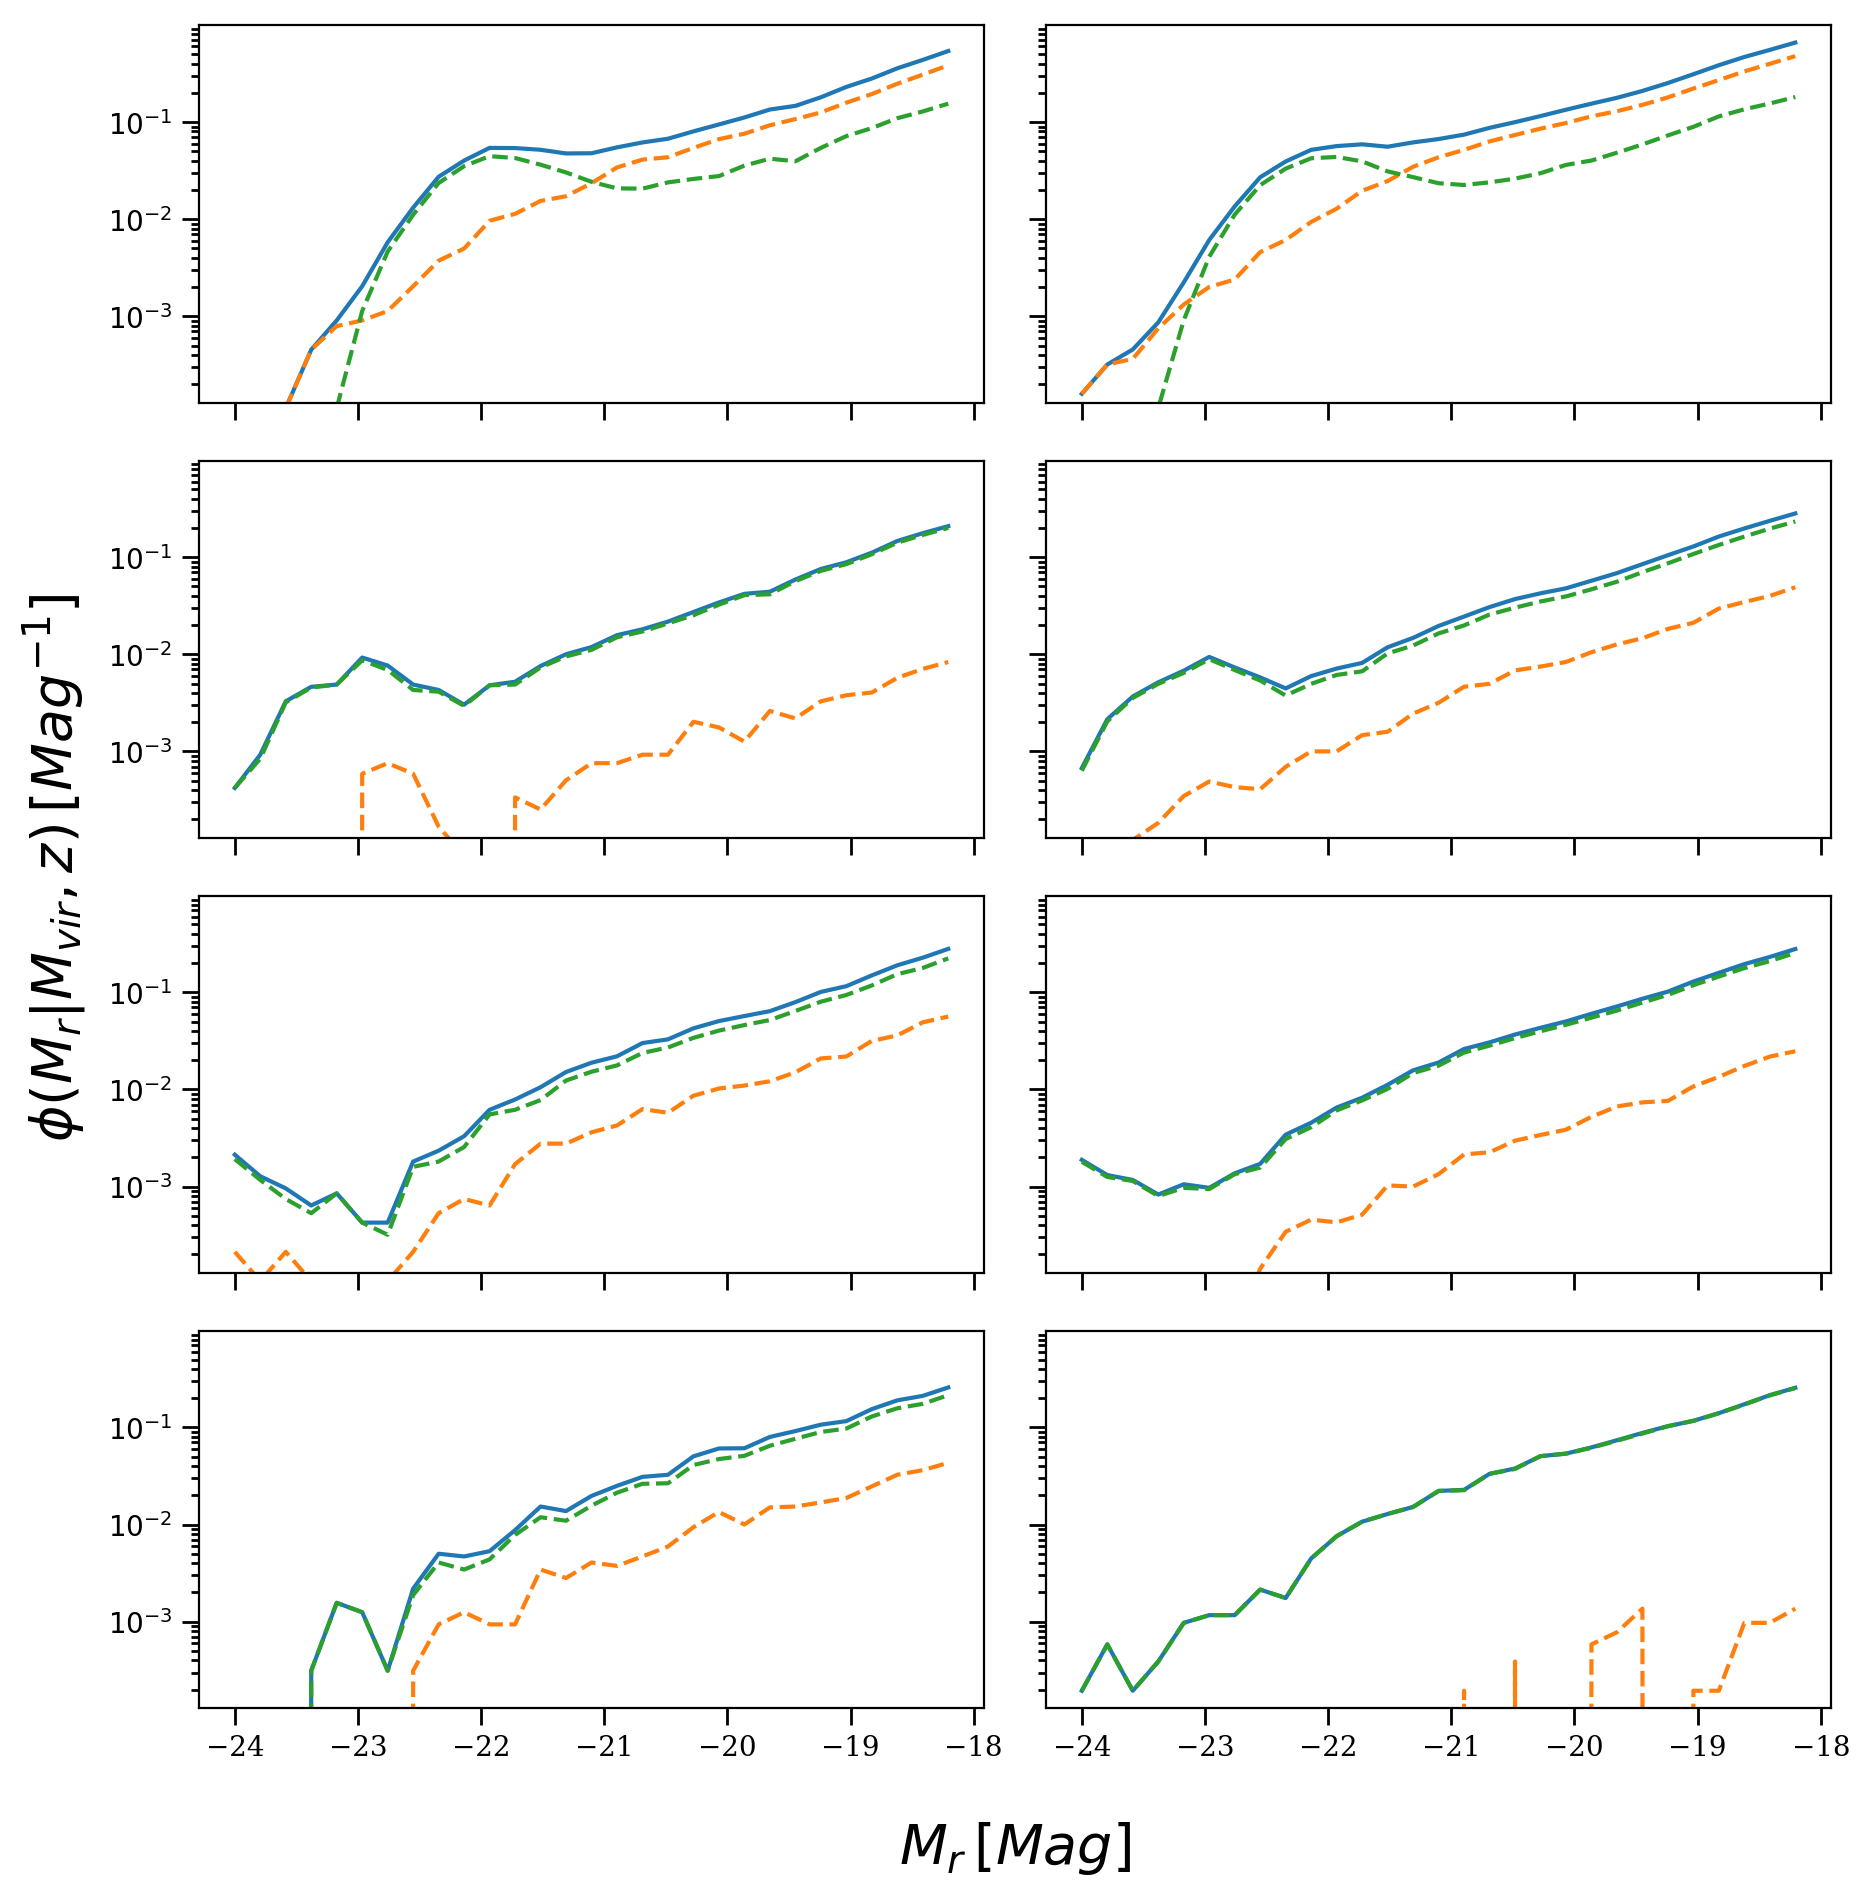

In [32]:
f, ax = plt.subplots(buzzard_clf.n_mass_bins, buzzard_clf.n_z_bins, sharex=True, sharey=True)

for i in range(buzzard_clf.n_z_bins):
    for j in range(buzzard_clf.n_mass_bins):
        ax[j,i].plot(alphaq_clf.magnitude_bins[:-1], alphaq_clf.tot_clf[:,j,i])
        ax[j,i].plot(alphaq_clf.magnitude_bins[:-1], alphaq_clf.sat_clf[:,j,i], '--')
        ax[j,i].plot(alphaq_clf.magnitude_bins[:-1], alphaq_clf.cen_clf[:,j,i], '--')
        
        ax[j,i].set_yscale('log')

        
sax = f.add_subplot(111)
plt.setp(sax.get_xticklines(), visible=False)
plt.setp(sax.get_yticklines(), visible=False)
plt.setp(sax.get_xticklabels(), visible=False)
plt.setp(sax.get_yticklabels(), visible=False)
sax.patch.set_alpha(0.0)
sax.patch.set_facecolor('none')
sax.spines['top'].set_color('none')
sax.spines['top'].set_alpha(0.0)
sax.spines['bottom'].set_color('none')
sax.spines['bottom'].set_alpha(0.0)
sax.spines['left'].set_color('none')
sax.spines['left'].set_alpha(0.0)
sax.spines['right'].set_color('none')
sax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
sax.set_ylabel(r'$\phi(M_{r}|M_{vir},z)\/[Mag^{-1}]$', labelpad=40, fontsize=20)
sax.set_xlabel(r'$M_{r}\/[Mag]$', labelpad=40, fontsize=20)
f.set_figheight(10)
f.set_figwidth(10)
plt.tight_layout()


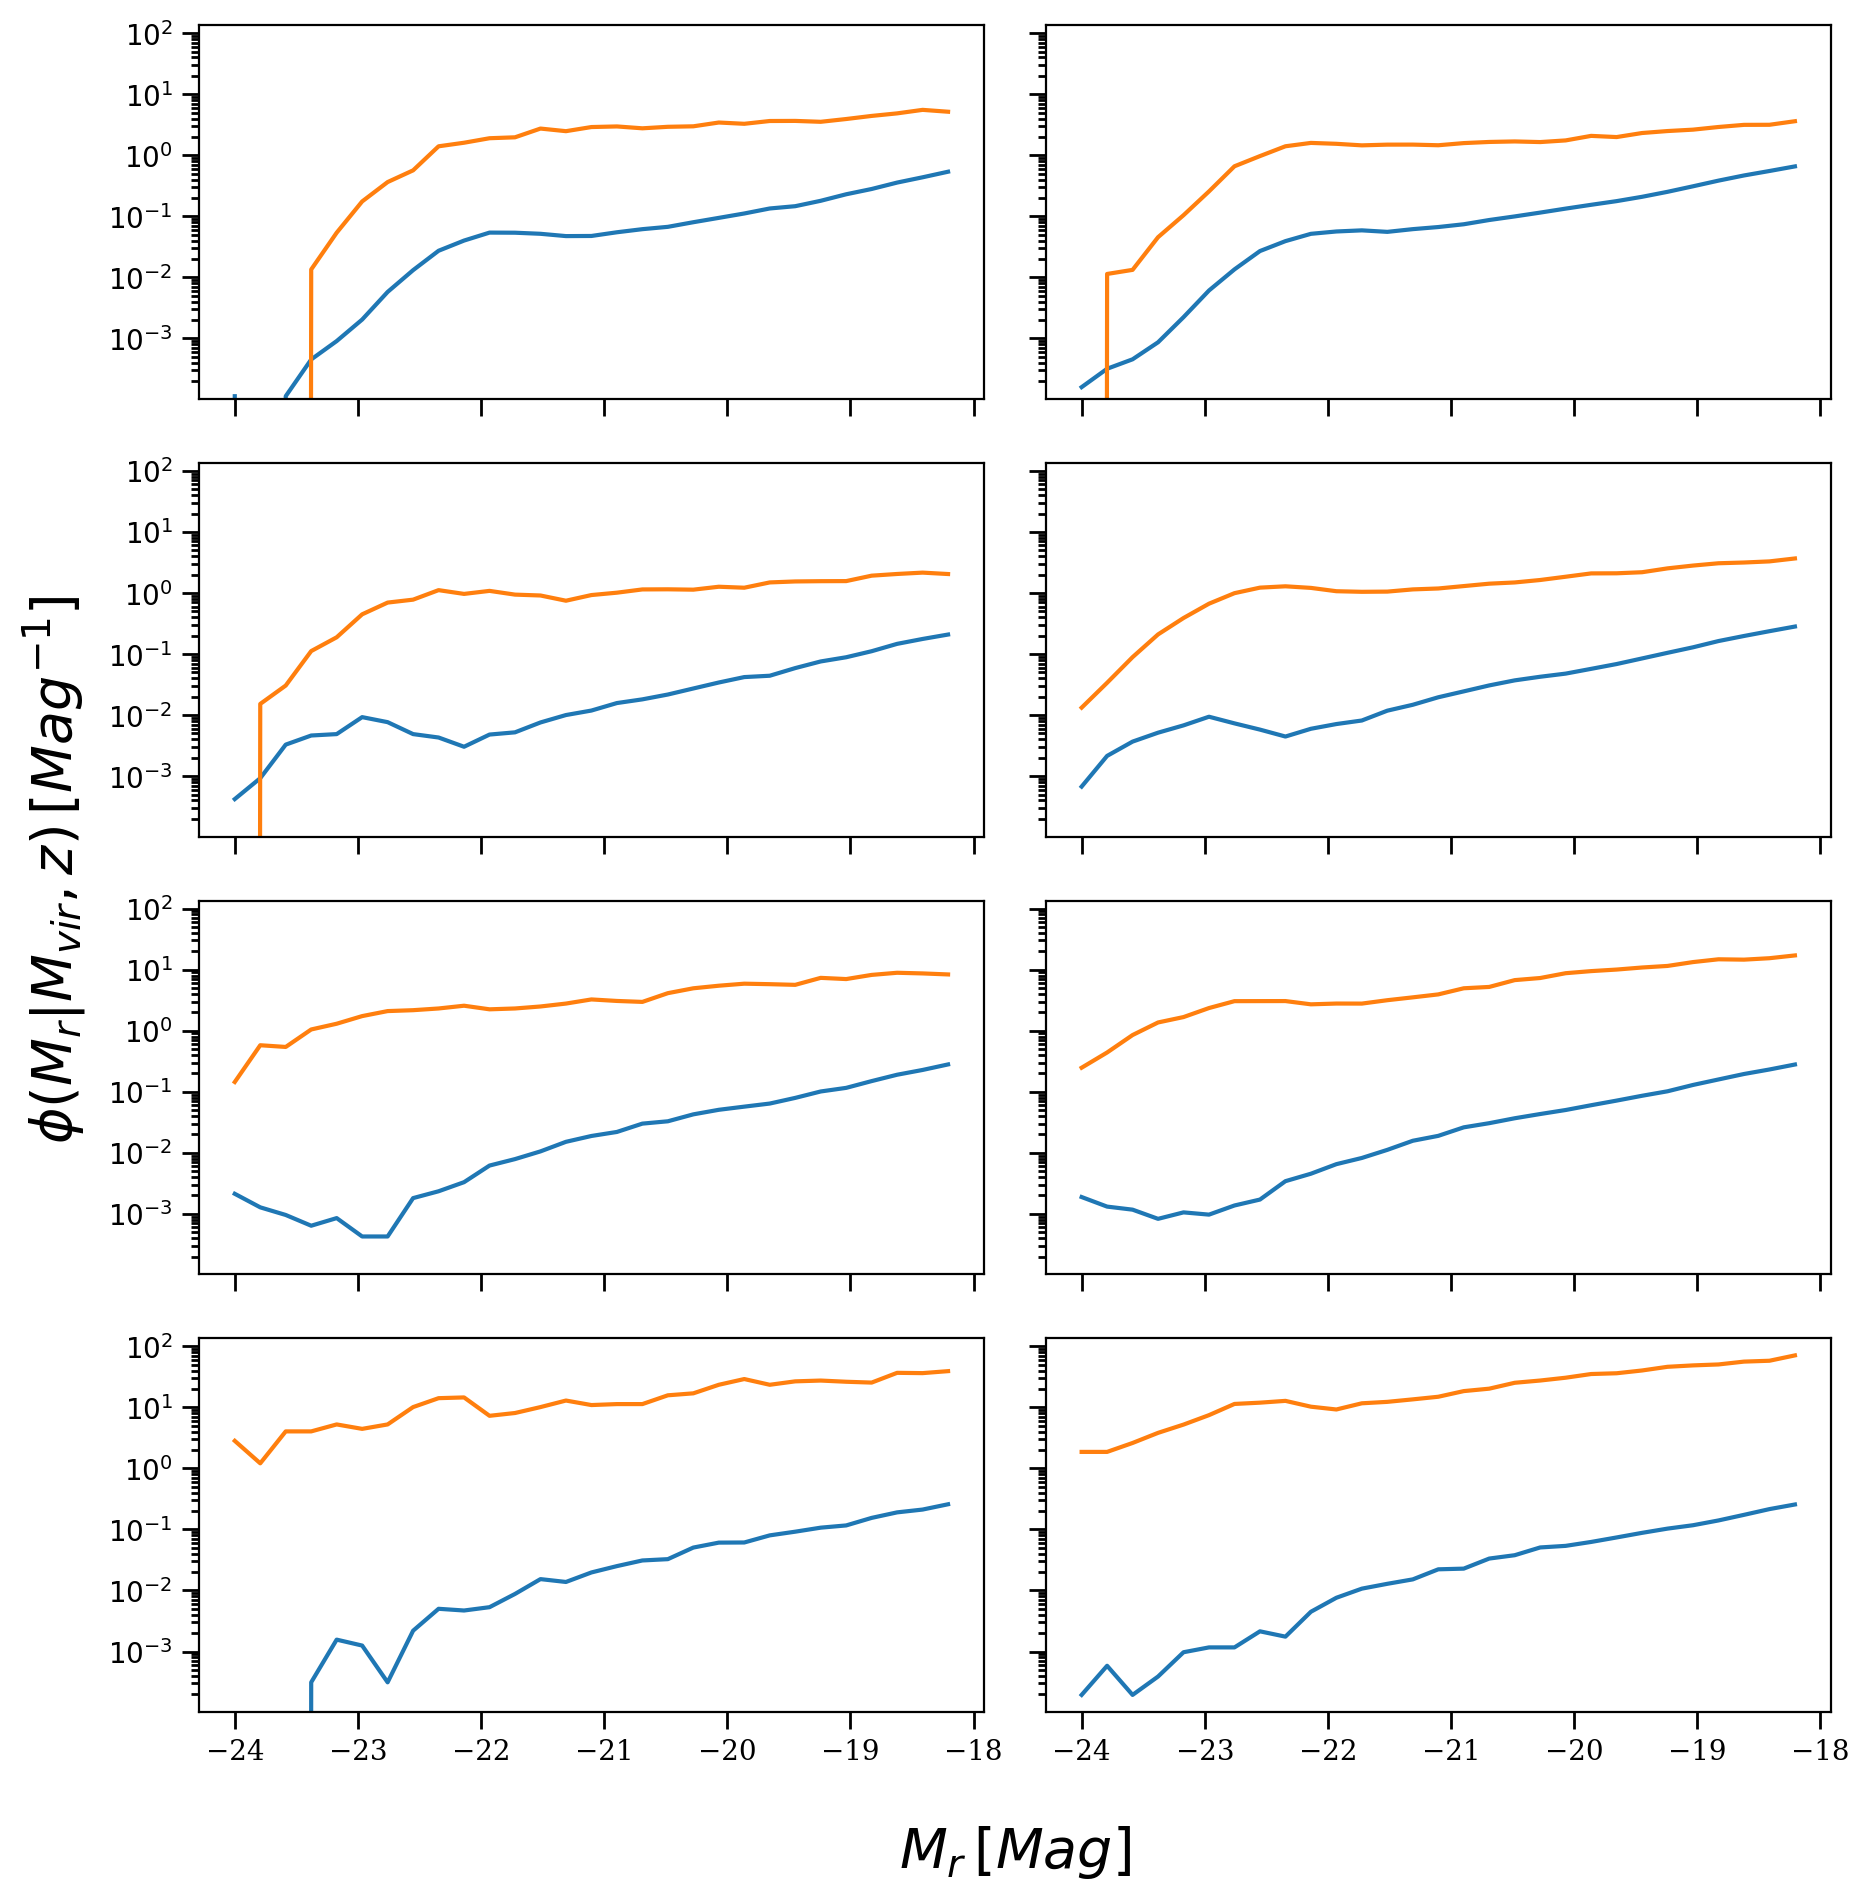

In [25]:
f, ax = plt.subplots(buzzard_clf.n_mass_bins, buzzard_clf.n_z_bins, sharex=True, sharey=True)

for i in range(buzzard_clf.n_z_bins):
    for j in range(buzzard_clf.n_mass_bins):
        ax[j,i].plot(alphaq_clf.magnitude_bins[:-1], alphaq_clf.tot_clf[:,j,i], label='Proto-DC2')
        ax[j,i].plot(buzzard_clf.magnitude_bins[:-1], buzzard_clf.tot_clf[:,j,i], label='Buzzard')
        
        ax[j,i].set_yscale('log')

        
sax = f.add_subplot(111)
plt.setp(sax.get_xticklines(), visible=False)
plt.setp(sax.get_yticklines(), visible=False)
plt.setp(sax.get_xticklabels(), visible=False)
plt.setp(sax.get_yticklabels(), visible=False)
sax.patch.set_alpha(0.0)
sax.patch.set_facecolor('none')
sax.spines['top'].set_color('none')
sax.spines['top'].set_alpha(0.0)
sax.spines['bottom'].set_color('none')
sax.spines['bottom'].set_alpha(0.0)
sax.spines['left'].set_color('none')
sax.spines['left'].set_alpha(0.0)
sax.spines['right'].set_color('none')
sax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
sax.set_ylabel(r'$\phi(M_{r}|M_{vir},z)\/[Mag^{-1}]$', labelpad=40, fontsize=20)
sax.set_xlabel(r'$M_{r}\/[Mag]$', labelpad=40, fontsize=20)
f.set_figheight(10)
f.set_figwidth(10)
plt.legend()
plt.tight_layout()


In [22]:
print(alphaq_clf.halo_counts)
print(buzzard_clf.halo_counts)


[[  42613.  211912.]
 [  57383.  236363.]
 [  45388.  169231.]
 [  15437.   24822.]]
[[  358.  2544.]
 [  951.  6571.]
 [  134.   958.]
 [   12.    52.]]


In [23]:
print(alphaq_clf.sat_lum_counts)
print(buzzard_clf.sat_lum_counts)


[[[  1.00000000e+00   7.00000000e+00]
  [  0.00000000e+00   2.00000000e+00]
  [  2.00000000e+00   3.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   1.40000000e+01]
  [  1.00000000e+00   5.00000000e+00]
  [  1.00000000e+00   2.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  1.00000000e+00   1.60000000e+01]
  [  1.00000000e+00   6.00000000e+00]
  [  2.00000000e+00   1.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  4.00000000e+00   3.30000000e+01]
  [  1.00000000e+00   9.00000000e+00]
  [  1.00000000e+00   1.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  7.00000000e+00   5.80000000e+01]
  [  0.00000000e+00   1.70000000e+01]
  [  0.00000000e+00   3.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  8.00000000e+00   8.80000000e+01]
  [  7.00000000e+00   2.40000000e+01]
  [  0.00000000e+00   1.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  1.00000000e+01   1.05000000e+02]
  [  9.00000000e+00   2.10000000e+01]


(array([[ 17174.,  13855.,  16373.,  18373.,  14793.,  14707.,  12952.,
          13056.,  22460.,  15653.,  14965.,  16773.,  16184.,  16179.,
          18979.,  24931.,  21170.,  23581.,  21844.,  21160.,  19556.,
          28790.,  30305.,  18745.,  21418.,  19293.,  20906.,  19617.,
          17480.,  18975.],
        [ 20601.,  22339.,  14334.,  17167.,  13861.,  14722.,  14273.,
          15760.,  19820.,  21114.,  14732.,  15602.,  19247.,  17655.,
          20831.,  22991.,  22420.,  20486.,  20844.,  20917.,  20748.,
          22382.,  19527.,  17876.,  20717.,  20166.,  21654.,  24539.,
          24389.,  21468.],
        [ 21762.,  20617.,  17101.,  16935.,  16822.,  17452.,  16327.,
          18364.,  18071.,  16932.,  16676.,  18991.,  16325.,  16267.,
          22313.,  15810.,  20654.,  19828.,  18381.,  25167.,  21739.,
          18718.,  18343.,  18547.,  16820.,  16769.,  19642.,  23252.,
          19181.,  19533.],
        [ 18176.,  16574.,  17046.,  16140.,  16288.

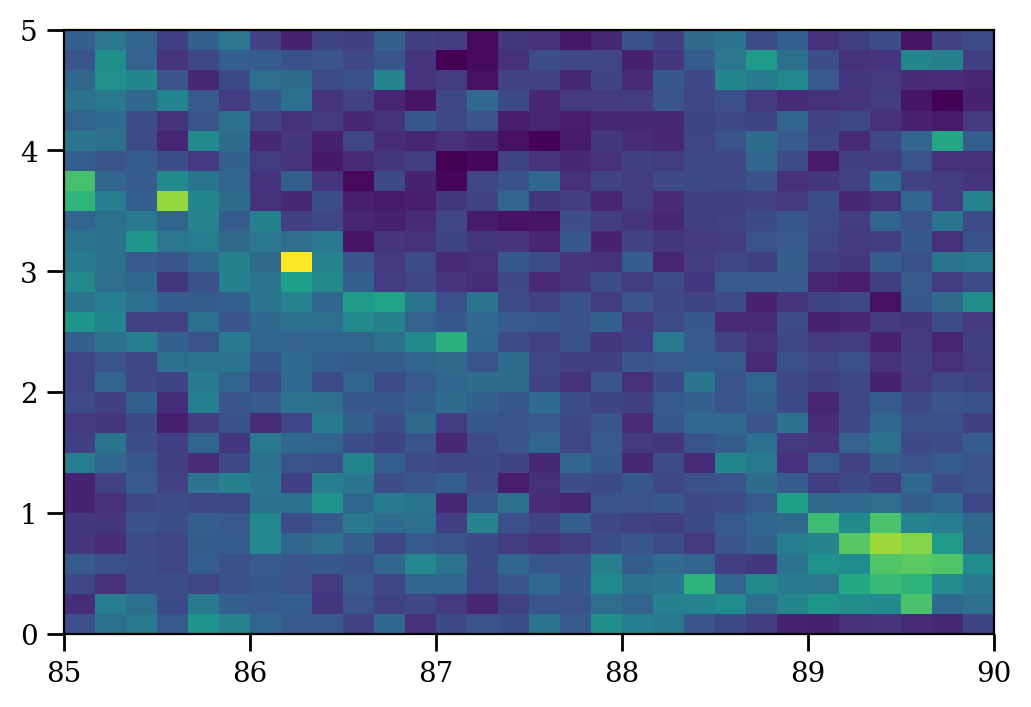

In [21]:
plt.hist2d(data_alphaq['ra']/60**2, data_alphaq['dec']/60**2, bins=30)